In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from scipy import stats

In order to use this notebook please make sure to have a file named "historical_data" in a directory named "processed_data" which includes the variables BESS, RESP and NG_Price, together with the revenue of EMS of all 3 markets labelled "Intraday", "Imbalance", and "Day-ahead Only" on a monthly basis. These files are required for model training. In order to perform the forecasting task, you should also have a file in the directory "processed data" which includes the variables used in the training file called "future_data". These are the default values for the paths in the train_model function and forecast_with_scenarios_function, however, they can also be changed if needed.

Some of the parameters from the function require extra files, but they are not necessary.

# Functions

In [233]:
def train_model(feature_names=["RESP", "NG_Price", "BESS"], outcome="Imbalance",
                            historical_data_path="processed_data/historical_data.csv", show_summary=True, scale=True):
    historical_data = pd.read_csv(historical_data_path, parse_dates=["Date"])
    historical_data.set_index("Date", inplace=True)
    historical_data["month"] = historical_data.index.month

    # Monthly dummies (excluding the first to avoid multicollinearity)
    month_dummies = pd.get_dummies(historical_data["month"], prefix="Month", drop_first=True)

    # Features and target
    X = pd.concat([historical_data[feature_names], month_dummies], axis=1).astype(float)
    y = historical_data[outcome]

    # Remove outliers
    z = np.abs(stats.zscore(y))
    threshold = 3
    outliers = np.where(z > threshold)[0]
    X = X.drop(X.index[outliers])
    y = y.drop(y.index[outliers])

    #Feature scaling
    if scale:
        scaler = StandardScaler()
        scaler.fit(X)
        X_scaled = scaler.fit_transform(X)
        X_const = sm.add_constant(X_scaled)
    else:
        X_const = sm.add_constant(X)
        scaler=None

    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    model = RidgeCV(cv=tscv, store_cv_results=False, alphas=np.logspace(-3, 3, 100)).fit(X_const, y)

    # Best model metrics
    best_alpha = model.alpha_
    y_pred = model.predict(X_const)
    mae = mean_absolute_error(y, y_pred)

    #HISTORICAL RESIDUALS
    residuals = y - y_pred

    if show_summary:
        print(f"✅ Best Alpha: {best_alpha}")
        print(f"✅ Mean Absolute Error on Full Data: {mae:.4f}")

    return model, residuals, scaler

def forecast_with_scenarios(model, residuals, scaler, outcome="Imbalance", feature_names=["RESP", "NG_Price", "BESS"],
                            future_data_path="processed_data/future_data.csv",
                            historical_data_path="processed_data/historical_data.csv",
                            show_plot=True, add_volatility=True):
    """
    Forecasts future scenarios using the trained model and specified features, including monthly dummies.
    Incorporates volatility by adjusting forecasts based on historical residuals.
    """
    future_data = pd.read_csv(future_data_path, parse_dates=["Date"])
    future_data["month"] = future_data["Date"].dt.month

    historical_data = pd.read_csv(historical_data_path, parse_dates=["Date"])
    historical_data.set_index("Date", inplace=True)

    # Prepare month dummies (must match training: months 2–12, drop January)
    month_dummies = pd.get_dummies(future_data["month"], prefix="Month", drop_first=True)

    # Mapping future scenario columns to standardized features
    scenario_mapping = {
        "RESP": ["Ra", "Rb", "Rc", "Rd", "Re", "Rf"],
        "NG_Price": ["Ga", "Gb", "Gc"],
        "BESS": ["Ba", "Bb", "Bc", "Bd", "Be", "Bf"],
    }

    scenario_combinations = list(itertools.product(
        *[scenario_mapping[key] for key in scenario_mapping.keys()]
    ))

    # Get the standard deviation of the residuals to incorporate volatility
    residuals_std = residuals.std()

    future_combination_dfs = []
    for combination in scenario_combinations:
        combination_name = "_".join(combination)

        try:
            # Base features
            temp_df = pd.DataFrame({
                "RESP": future_data[combination[0]].values,
                "NG_Price": future_data[combination[1]].values,
                "BESS": future_data[combination[2]].values,
            })

            # Combine with month dummies
            X_future = pd.concat([temp_df, month_dummies], axis=1)

            if scaler == None:
                x_future_scaled = sm.add_constant(X_future).astype(float)
            else:
                x_future_scaled = scaler.transform(X_future)
                x_future_scaled = sm.add_constant(x_future_scaled).astype(float)

            # Predict revenue
            revenue_forecast = model.predict(x_future_scaled)

            if add_volatility:
                # Adjust forecast for volatility (adding/subtracting based on residual std)
                adjusted_forecast = revenue_forecast + residuals_std * np.random.randn(len(revenue_forecast))
            else:
                adjusted_forecast = revenue_forecast

            # Store forecast
            future_comb_df = pd.DataFrame({
                "Date": future_data["Date"],
                f"Total Revenue Forecast ({combination_name})": adjusted_forecast
            })
            future_combination_dfs.append(future_comb_df.set_index("Date"))

        except KeyError as e:
            print(f"Missing column in combination {combination}: {e}")
            continue

    all_forecasts = pd.concat(future_combination_dfs, axis=1)

    if show_plot:
        plt.figure(figsize=(20, 5))
        plt.plot(historical_data.index, historical_data[outcome], label="Historical Revenue")
        for column in all_forecasts.columns:
            plt.plot(all_forecasts.index, all_forecasts[column], label=column)
        plt.title(f"Forecasts for {outcome} Revenue Across Scenarios")
        plt.grid(True)
        plt.show()

    return all_forecasts

def create_annualized_forecast(scenarios, low_factors, mid_factors, high_factors, 
                               save_folder="forecasts", show_monthly_plots=False,
                               add_montel_curves=False):
    """
    Creates annualized forecasts for different scenarios based on specified factors.
    """
    
    # create directories for each scenario in the save folder
    for scenario in scenarios:
        os.makedirs(f"{save_folder}/forecasts_{scenario}", exist_ok=True)

    low_mid_factors = [low_factors[0], mid_factors[1]]
    high_mid_factors = [high_factors[0], mid_factors[1]]
    mid_high_factors = [mid_factors[0], high_factors[1]]
    mid_low_factors = [mid_factors[0], low_factors[1]]
    low_high_factors = [low_factors[0], high_factors[1]]
    high_low_factors = [high_factors[0], low_factors[1]]

    dict = {}
    tipping_points = ["2028-01-01", "2034-01-01"]

    monthly_forecasts = pd.read_csv(f"{save_folder}/total_revenue_summed_forecasts_combined.csv", parse_dates=["Date"])
    monthly_forecasts.set_index("Date", inplace=True)

    for scenario in scenarios:
        if scenario == "low":
            factors = low_factors
        elif scenario == "mid":
            factors = mid_factors
        elif scenario == "high":
            factors = high_factors
        elif scenario == "low_mid":
            factors = low_mid_factors
        elif scenario == "high_mid":
            factors = high_mid_factors
        elif scenario == "mid_high":
            factors = mid_high_factors
        elif scenario == "mid_low":
            factors = mid_low_factors
        elif scenario == "low_high":
            factors = low_high_factors
        elif scenario == "high_low":
            factors = high_low_factors

        monthly_forecasts_adjusted = smooth_tipping_adjustment(monthly_forecasts, tipping_points, factors, width_years=4)
        monthly_forecasts_adjusted.to_csv(f"{save_folder}/forecasts_{scenario}/total_revenue_summed_forecasts_combined_adjusted_{scenario}.csv", index=True, header=True)

        forecast_data = pd.read_csv(f"{save_folder}/forecasts_{scenario}/total_revenue_summed_forecasts_combined_adjusted_{scenario}.csv", parse_dates=["Date"])
        forecast_data.set_index("Date", inplace=True)

        monthly_reference = forecast_data.groupby(forecast_data.index.month).transform("first")
        forecast_data_percentage = forecast_data / monthly_reference

        if show_monthly_plots:
            # plot the percentage change for each scenario
            plt.figure(figsize=(20, 5))
            for column in forecast_data_percentage.columns:
                current_forecast = forecast_data_percentage[forecast_data_percentage.index.year != 2025]
                plt.plot(current_forecast.index, current_forecast[column] * 100, label=column)

            # Highlight year ranges with shadowed rectangles
            highlight_ranges = [
                ('2026-01-01', '2030-01-01', 'lightgreen'),
                ('2030-01-01', '2050-01-01', 'lightpink')
            ]
            for start, end, color in highlight_ranges:
                plt.axvspan(pd.Timestamp(start), pd.Timestamp(end), color=color, alpha=0.2)

            plt.title(f"Monthly Revenues as % of 2025 Revenues for Scenario: {scenario}")
            plt.xlabel("Date")
            plt.ylabel("Percentage Change")
            plt.show()

        forecast_data_percentage.T.to_excel(f"{save_folder}/forecasts_{scenario}/monthly_revenue_forecasts_percentage_{scenario}.xlsx", index=True, header=True)
        forecast_data_percentage.to_csv(f"{save_folder}/forecasts_{scenario}/monthly_revenue_forecasts_percentage_{scenario}.csv", index=True, header=True)

        forecast_data = pd.read_csv(f"{save_folder}/forecasts_{scenario}/total_revenue_summed_forecasts_combined_adjusted_{scenario}.csv", parse_dates=["Date"])
        forecast_data.set_index("Date", inplace=True)

        # Resample to yearly data using sum
        yearly_revenue = forecast_data.resample('YE').sum()

        # Convert the Date index to the year format
        yearly_revenue.index = yearly_revenue.index.year

        # Select the base year (2025)
        base_year = yearly_revenue.iloc[0]
        base_year_values = base_year.values

        # Calculate percentage change compared to 2025
        percentage_change = (yearly_revenue / base_year_values) * 100

        # Reset index for easier viewing
        percentage_change.reset_index(inplace=True)
        percentage_change.rename(columns={"index": "Year"}, inplace=True)

        # Save the result to a new CSV
        percentage_change.to_csv(f"{save_folder}/forecasts_{scenario}/yearly_revenue_percentage_change_{scenario}.csv", index=False)
        percentage_change.T.to_excel(f"{save_folder}/forecasts_{scenario}/yearly_revenue_percentage_change_{scenario}.xlsx", index=False)

        dict[scenario] = pd.read_csv(f"{save_folder}/forecasts_{scenario}/yearly_revenue_percentage_change_{scenario}.csv", parse_dates=["Date"])

        print(f"Scenario {scenario} processed.")

    # Plot the original and random trends
    plt.figure(figsize=(20, 5))
    for scenario in dict.keys():
        forecast_data = dict[scenario]
        forecast_data.set_index("Date", inplace=True)
        for column in forecast_data.columns:
            plt.plot(forecast_data.index, forecast_data[column], linewidth=0.8, label=column)

    # Highlight year ranges with shadowed rectangles
    highlight_ranges = [
        ('2025-01-01', '2030-01-01', 'lightgreen'),
        ('2030-01-01', '2050-01-01', 'lightpink')
    ]
    for start, end, color in highlight_ranges:
        plt.axvspan(pd.Timestamp(start), pd.Timestamp(end), color=color, alpha=0.2)

    if add_montel_curves:
        std_montel = pd.read_csv(f"{save_folder}/standardized_scenarios_montel.csv", parse_dates=["Year"])
        std_montel.set_index("Year", inplace=True)

        # convert strings with % at the end to float
        std_montel = std_montel.replace('%', '', regex=True).astype(float)
        std_montel += 100

        for column in std_montel.columns[1:]:
            plt.plot(std_montel.index, std_montel[column], label=column, linewidth=2, color="black")

    plt.plot()
    plt.xticks(forecast_data.index, forecast_data.index.year, rotation=45)
    plt.title(f"Yearly Revenues as % of 2025 Revenues", fontsize=16)
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Revenue Forecast Normalized to 2025 (%)", fontsize=14)
    plt.show()

def smooth_tipping_adjustment(df, tipping_points, factors, width_years=2):
    """
    Applies smooth multiplicative adjustments to forecast based on tipping points.

    Parameters:
    - df (DataFrame): Time-indexed forecast data
    - tipping_points (list of str): Years (or datetime-like) where transitions begin
    - factors (list of float): Multipliers applied after each tipping point
    - width_years (float): Width of the transition period (in years)

    Returns:
    - adjusted_df (DataFrame): DataFrame with smoothly adjusted forecasts
    """
    df = df.copy()
    years = df.index.year + df.index.dayofyear / 365.25
    adjustment = np.ones(len(df))

    for i, (tp, factor) in enumerate(zip(tipping_points, factors)):
        tp_year = pd.to_datetime(tp).year
        # Smooth sigmoid transition
        transition = 1 / (1 + np.exp(-(years - tp_year) * (4 / width_years)))
        if i == 0:
            prev_factor = 1.0
        else:
            prev_factor = factors[i - 1]
        # Linear blend between previous and new factor
        adjustment *= (prev_factor + (factor - prev_factor) * transition)

    # Apply multiplicative adjustment
    df_adjusted = df.multiply(adjustment, axis=0)
    return df_adjusted

# Trainig and Forecasting

In [ ]:
model, residuals, scaler = train_model(outcome="Intraday", show_summary=True, scale=False)
forecasts_id = forecast_with_scenarios(model, residuals, scaler, outcome="Intraday", add_volatility=False)
forecasts_id.to_csv("forecasts/intraday_revenue_forecasts_combined.csv")

model, residuals, scaler = train_model(outcome="Imbalance", show_summary=True)
forecasts_im = forecast_with_scenarios(model, residuals, scaler, outcome="Imbalance", add_volatility=False)
forecasts_im.to_csv("forecasts/imbalance_revenue_forecasts_combined.csv")

model, residuals, scaler = train_model(outcome="Day-ahead Only", show_summary=True)
forecasts_da = forecast_with_scenarios(model, residuals, scaler, outcome="Day-ahead Only", add_volatility=False)
forecasts_da.to_csv("forecasts/day_ahead_revenue_forecasts_combined.csv")

# Combining Forecasts

In [ ]:
imbalance_revenue_forecasts = pd.read_csv("forecasts/imbalance_revenue_forecasts_combined.csv", parse_dates=["Date"])
imbalance_revenue_forecasts.set_index("Date", inplace=True)
day_ahead_revenue_forecasts = pd.read_csv("forecasts/day_ahead_revenue_forecasts_combined.csv", parse_dates=["Date"])
day_ahead_revenue_forecasts.set_index("Date", inplace=True)
intraday_revenue_forecasts = pd.read_csv("forecasts/intraday_revenue_forecasts_combined.csv", parse_dates=["Date"])
intraday_revenue_forecasts.set_index("Date", inplace=True)

total_revenue = pd.DataFrame(index = imbalance_revenue_forecasts.index, columns = day_ahead_revenue_forecasts.columns)
total_revenue.index.name = "Date"

for i in range(len(total_revenue.columns)):
    total_revenue.iloc[:, i] = imbalance_revenue_forecasts.iloc[:, i] + day_ahead_revenue_forecasts.iloc[:, i] + intraday_revenue_forecasts.iloc[:, i]

# Load historical dataset
historical_data = pd.read_csv("processed_data/historical_data.csv", parse_dates=["Date"])
historical_data.set_index("Date", inplace=True)

# Plot historical data
plt.figure(figsize=(20, 5))
plt.plot(historical_data.index, historical_data["Total"], label="Historical Revenue")

for column in total_revenue.columns:
    plt.plot(total_revenue.index, total_revenue[column], label=column)
plt.show()

total_revenue.to_csv("forecasts/total_revenue_summed_forecasts_combined.csv")

# Annualising and Scenario Building

Scenario low processed.
Scenario mid processed.
Scenario high processed.
Scenario low_mid processed.
Scenario high_mid processed.
Scenario mid_high processed.
Scenario mid_low processed.
Scenario low_high processed.
Scenario high_low processed.


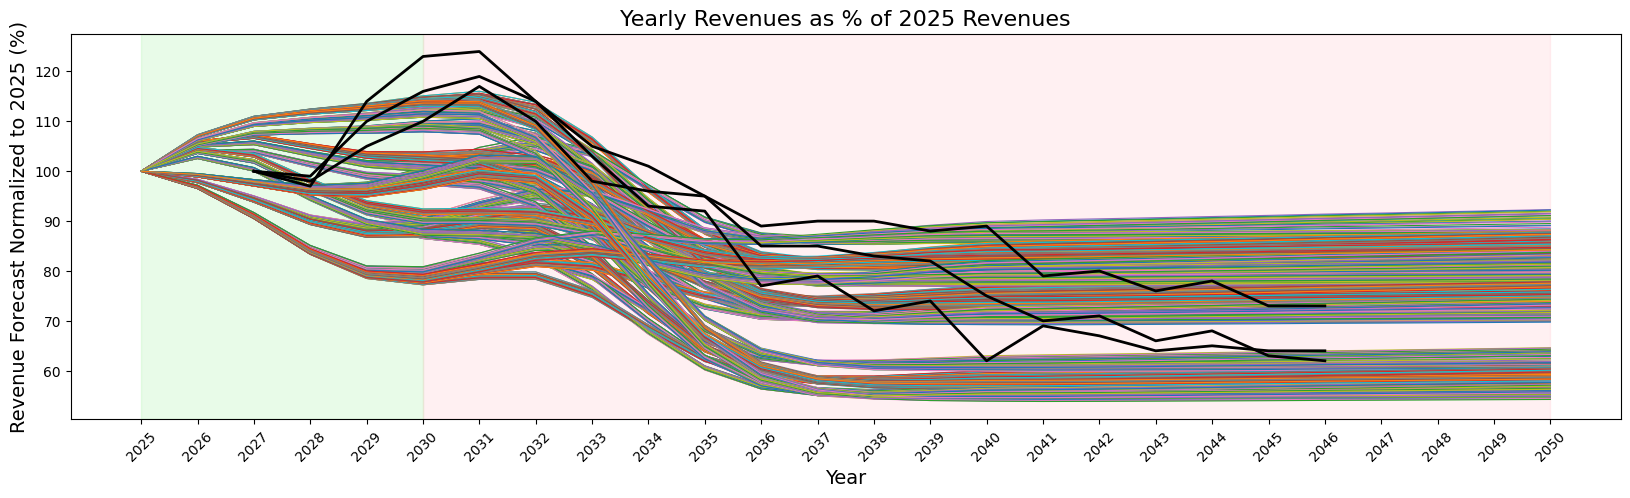

In [234]:
scenarios = ["low", "mid", "high", "low_mid", "high_mid", "mid_high", "mid_low", "low_high", "high_low"]

low_factors = [0.65, 0.35]
mid_factors = [0.75, 0.45]
high_factors = [0.85, 0.50]

create_annualized_forecast(scenarios, low_factors, mid_factors, high_factors, 
                           save_folder="forecasts", show_monthly_plots=False, 
                           add_montel_curves=True)